# PDEfind Usage Examples

We discuss how to use the PDEfind library on specific examples. 

## Diffusion equation

Consider the equation 
$$\partial_t u(t,x) = \partial_x^2 u(t,x)$$
on $(t, x) \in [0,1] \times [0,1]$ with Dirichlet boundary conditions.

First, prepare the mock data.

In [9]:
# prepare mock data - copied from https://docs.sciml.ai/MethodOfLines/dev/tutorials/heat/
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets

# Parameters, variables, and derivatives
@parameters t x
@variables u(..)
Dt = Differential(t)
Dxx = Differential(x)^2

# 1D PDE and boundary conditions
eq  = Dt(u(t, x)) ~ Dxx(u(t, x))
bcs = [u(0, x) ~ (sin(pi*x) + 0.5* sin(3*pi*x)),
        u(t, 0) ~ 0.0,
        u(t, 1) ~ 0.0]

# Space and time domains
domains = [t ∈ Interval(0.0, 0.3),
           x ∈ Interval(0.0, 1.0)]

# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])

# Method of lines discretization
dx = 0.002
order = 2 # not used
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)

# Solve ODE problem
sol = solve(prob, Tsit5(), saveat=0.001)

L"\begin{align}
 - \frac{\mathrm{d}}{\mathrm{d}x} \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) + \frac{\mathrm{d}}{\mathrm{d}t} u\left( t, x \right) =& 0
\end{align}
"

PDESolution:
  Return Code:
    Success
  Dependent variables:
    u(t, x): (301, 501) sized solution
  Domain:
    t ∈ (0.0, 0.3) with 301 points, step size 0.001
    x ∈ (0.0, 1.0) with 501 points, step size 0.002
  From system:
    Equations:
    Boundary/Initial Conditions:


L"\begin{align}
u\left( 0, x \right) =& 0.5 \sin\left( 9.4248 x \right) + \sin\left( \pi x \right) \\
u\left( t, 0 \right) =& 0 \\
u\left( t, 1 \right) =& 0
\end{align}
"

Import the package

In [10]:
using PDEfind

We pretend that all that is given are the following arrays, which we collect in a grid structure.

In [11]:
# start with given data
time_range = 0.0:0.002:0.3
space_range = 0.0:0.004:1.0
data_array = sol(time_range, space_range)[1]
time_array = collect(time_range)
space_array= collect(space_range)

# initialize grid
g = TimeSpaceGrid1D(time_array, space_array)

TimeSpaceGrid1D{Float64}([0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018  …  0.282, 0.284, 0.286, 0.288, 0.29, 0.292, 0.294, 0.296, 0.298, 0.3], [0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036  …  0.964, 0.968, 0.972, 0.976, 0.98, 0.984, 0.988, 0.992, 0.996, 1.0], 0.002, 0.004, 151, 251, 37901, [0.0 0.002 … 0.298 0.3; 0.0 0.002 … 0.298 0.3; … ; 0.0 0.002 … 0.298 0.3; 0.0 0.002 … 0.298 0.3], [0.0 0.0 … 0.0 0.0; 0.004 0.004 … 0.004 0.004; … ; 0.996 0.996 … 0.996 0.996; 1.0 1.0 … 1.0 1.0])

We are solving an equation of the type $\partial_t u_(t,x) = \mathcal L [u(t,x)]$ for unknown $\mathcal L$. 

In this example we assume $\mathcal L$ is a polynomial in $u, \partial_x u, \partial_{xx} u$. Using notation from Rudy et al., we prepare the $\Theta$ matrix. 

Note: `normalization_factors` are an irrelevant trick used for stability of the algorithm.

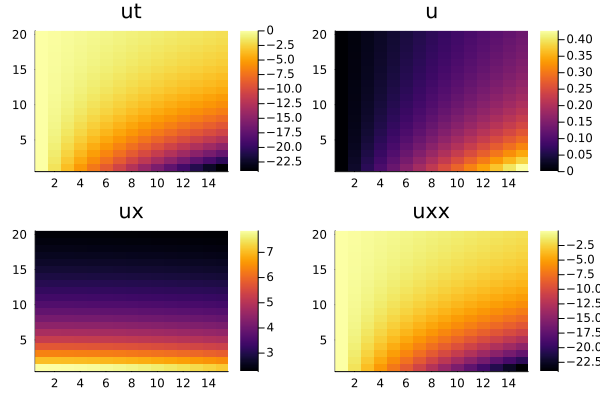

In [12]:
# prepare LHS
# make finite difference operator
∂t = TimeDerivative(g, order=4) # takes BC and order as arguments
dt_data_array = ∂t(data_array) 
dt_data_array_flat = reshape(dt_data_array, g.N) 

# prepare RHS
# construct relevant variables from highest order spatial derivative to consider
∂x = XDerivative(g; order=4) # takes BC and order as arguments
max_derivative_degree = 3
variables_matrix = GetVariablesMatrix(max_derivative_degree, data_array, g, ∂x)

# check accuracy of numerical derivatives
using Plots
p1 = heatmap(reshape(dt_data_array_flat ,(g.nt,g.nx))[1:20,1:15], title="ut")
p2 = heatmap(reshape(variables_matrix[1],(g.nt,g.nx))[1:20,1:15], title="u")
p3 = heatmap(reshape(variables_matrix[2],(g.nt,g.nx))[1:20,1:15], title="ux")
p4 = heatmap(reshape(variables_matrix[3],(g.nt,g.nx))[1:20,1:15], title="uxx")
plot(p1, p2, p3, p4, layout = (2,2))

In [13]:
# construct basis functions, eg: polynomial basis
max_poly_degree = 2
n_variables = max_derivative_degree + 1 # include 0th-derivative i.e. function itself
MyBasis = PolynomialBasis(max_poly_degree, n_variables, skip_constant = false)

# theta matrix
Θ = evaluate(MyBasis, variables_matrix)
# cond_number = norm(Θ,2) * norm(pinv(Θ),2)

37901×15 Matrix{Float64}:
 1.0  0.0   7.85398   -0.000757667  -448.551    …   0.339853        2.01198e5
 1.0  0.0   7.02595   -0.000636416  -380.131        0.241922        1.445e5
 1.0  0.0   6.32436   -0.000535209  -322.741        0.172734        1.04162e5
 1.0  0.0   5.7262    -0.000446703  -274.247        0.122507    75211.5
 1.0  0.0   5.21783   -0.000374934  -233.797        0.0876585   54661.1
 1.0  0.0   4.78562   -0.000314778  -199.869    …   0.0629145   39947.6
 1.0  0.0   4.41413   -0.000264353  -171.357        0.0452988   29363.3
 1.0  0.0   4.09407   -0.000222128  -147.384        0.0327381   21722.1
 1.0  0.0   3.82046   -0.00018675   -127.281        0.0237696   16200.4
 1.0  0.0   3.58383   -0.000157123  -110.38         0.0173431   12183.7
 ⋮                                              ⋱               
 1.0  0.0  -0.190505  -3.789e-7        1.87969     -7.12214e-7      3.53323
 1.0  0.0  -0.186707  -3.71347e-7      1.84222     -6.84101e-7      3.39376
 1.0  0.0  -0.183105 

Perform sequential thresholded ridge regression at *fixed threshold* and *fixed* $\lambda$.

In [14]:
# perform ridge regression
STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-3, tol = 1e-1, iters = 4, verbose = true, normalize_columns = false)

Iteration: 4, threshold: 0.1. 
Iteration: 3, threshold: 0.1. 
Iteration: 2, threshold: 0.1. 
Iteration: 1, threshold: 0.1. 


Current fit: 
 $ \\ \partial_t u = \textcolor{grey}{\xi_{0000}} + \textcolor{grey}{\xi_{1000}u} + \textcolor{grey}{\xi_{0100}\partial_{x} u} + \xi_{0010}\partial_{xx} u + \textcolor{grey}{\xi_{0001}\partial_{xxx} u} + \textcolor{grey}{\xi_{2000}(u)^2} + \textcolor{grey}{\xi_{1100}u\partial_{x} u} + \textcolor{grey}{\xi_{1010}u\partial_{xx} u} + \textcolor{grey}{\xi_{1001}u\partial_{xxx} u} + \textcolor{grey}{\xi_{0200}(\partial_{x} u)^2} + \textcolor{grey}{\xi_{0110}\partial_{x} u\partial_{xx} u} + \textcolor{grey}{\xi_{0101}\partial_{x} u\partial_{xxx} u} + \textcolor{grey}{\xi_{0020}(\partial_{xx} u)^2} + \textcolor{grey}{\xi_{0011}\partial_{xx} u\partial_{xxx} u} + \textcolor{grey}{\xi_{0002}(\partial_{xxx} u)^2} \\ $ with: $ \\\textcolor{grey}{\xi_{0000} = 0.0 \\ }\textcolor{grey}{\xi_{1000} = -0.01 \\ }\textcolor{grey}{\xi_{0100} = -0.0 \\ }\xi_{0010} = 1.0 \\ \textcolor{grey}{\xi_{0001} = -0.0 \\ }\textcolor{grey}{\xi_{2000} = 0.01 \\ }\textcolor{grey}{\xi_{1100} = 0.01 \\ }\textcolor{grey}{\xi_{1010} = 0.0 \\ }\textcolor{grey}{\xi_{1001} = 0.0 \\ }\textcolor{grey}{\xi_{0200} = -0.0 \\ }\textcolor{grey}{\xi_{0110} = 0.0 \\ }\textcolor{grey}{\xi_{0101} = -0.0 \\ }\textcolor{grey}{\xi_{0020} = 0.0 \\ }\textcolor{grey}{\xi_{0011} = 0.0 \\ }\textcolor{grey}{\xi_{0002} = -0.0 \\ }$ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u \\ $ with: $ \\\xi_{0010} = 1.0 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u \\ $ with: $ \\\xi_{0010} = 1.0 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u \\ $ with: $ \\\xi_{0010} = 1.0 \\ $ 
 - - -

([0.9998972186695589], Any[[0, 0, 1, 0]])

The threshold landscape exploration. 

In [15]:
using LinearAlgebra, Plots
N = g.N
cond_number = cond(Θ, 2)

tol_range = 10.0 .^ (-6:1e-2:1.0)
L2_error²_array = zero(tol_range)
L0_error²_array = zero(tol_range)

for (i,tol) in enumerate(tol_range)
    ξ, active_poly_vectors = STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ=1e-3, tol=tol, iters=5, verbose=false)
    chosen_mask = MyBasis.poly_vectors .∈ Ref(active_poly_vectors)
    L2_error²_array[i] = norm(Θ[:, chosen_mask] * ξ - dt_data_array_flat, 2)^2
    L0_error²_array[i] = norm(ξ, 0)^2
end

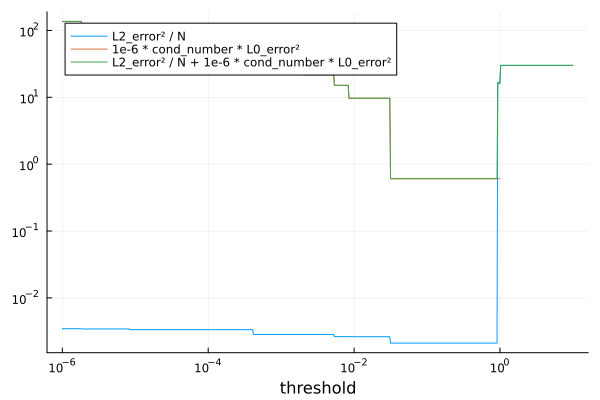

In [16]:
plot(tol_range, L2_error²_array ./ N, xscale=:log10, yscale=:log10, label="L2_error² / N", xlabel="threshold", legend=:topleft)
plot!(tol_range[L0_error²_array .> 0.], 1e-6 .* cond_number .* L0_error²_array[L0_error²_array .> 0.], label="1e-6 * cond_number * L0_error²")
plot!(tol_range, L2_error²_array ./ N + 1e-6 .* cond_number .* L0_error²_array, label="L2_error² / N + 1e-6 * cond_number * L0_error²")

Perform the choice of optimal threshold at *fixed* $\lambda$.

In [17]:
TrainSTRidge(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-3, tol_multiplier=1.0, iters = 5, verbose = true, cond_number_multiplier=1e-6,  max_tol_iters = 100)

Split input data to 30321 train and 7580 test samples. 
Using η = 1.0e-6 * 605301.1082059414. 
tol_iter = 1: Found better/equal fit with polynomials Any[], xi = Float64[]. Decreased Threshold to 2.5507190760328036. 
tol_iter = 2: Found better/equal fit with polynomials Any[[2, 0, 0, 0]], xi = [-18.24365044701047]. Decreased Threshold to 1.2753595380164018. 
tol_iter = 3: Found better/equal fit with polynomials Any[[0, 0, 1, 0]], xi = [0.9991092499730845]. Decreased Threshold to 0.6376797690082009. 
tol_iter = 4: Found better/equal fit with polynomials Any[[0, 0, 1, 0]], xi = [0.9991092499730845]. Decreased Threshold to 0.31883988450410045. 
tol_iter = 5: Found better/equal fit with polynomials Any[[0, 0, 1, 0]], xi = [0.9991092499730845]. Decreased Threshold to 0.15941994225205022. 
tol_iter = 6: Found better/equal fit with polynomials Any[[0, 0, 1, 0]], xi = [0.9991092499730845]. Decreased Threshold to 0.07970997112602511. 
tol_iter = 7: Found better/equal fit with polynomials Any[[0,

([0.9991092499730845], Any[[0, 0, 1, 0]])

Investigate behaviour at different $\lambda$.

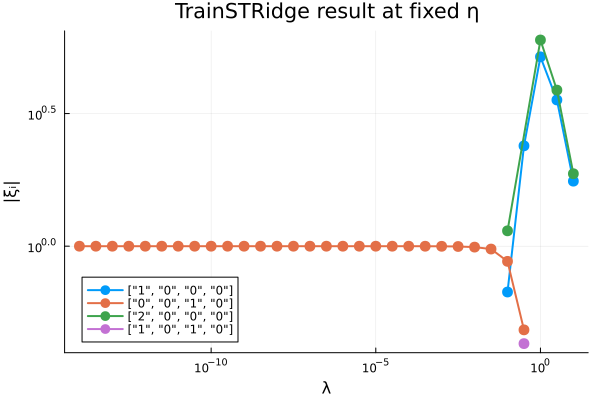

In [18]:
lambda_range = 10.0 .^ (-14.0:0.5:1.0)
to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5)

using Plots
plt = plot(legend=:bottomleft, xlabel="λ", ylabel="|ξᵢ|", title="TrainSTRidge result at fixed η")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end
display(plt)

## Advective diffusion 
Repeat the above for 
$$\partial_t u(t,x) = - 6 u(t,x) \partial_x u(t,x) + \partial_{xx} u(t,x),$$
on 

In [63]:
# prepare mock data - copied from https://docs.sciml.ai/MethodOfLines/dev/tutorials/heat/
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets

# Parameters, variables, and derivatives
@parameters t x
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2
Dxxx = Differential(x)^3

# 1D PDE and boundary conditions
eq  = Dt(u(t, x)) ~ - 6 * u(t,x) * Dx(u(t, x)) + 0.1 * Dxx(u(t,x))
bcs = [u(0, x) ~ (exp(- (x-0.5)^2 / (2 * 0.1^2))),
        u(t, 0) ~ u(t, 1)
        ]

# Space and time domains
domains = [t ∈ Interval(0.0, 1.0),
           x ∈ Interval(0.0, 1.0)]

# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])

# Method of lines discretization
dx = 0.002
order = 2 # not used
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)

# Solve ODE problem
sol = solve(prob, Tsit5(), saveat=0.001)

┌ Warning: The system contains interface boundaries, which are not compatible with system transformation. The system will not be transformed. Please post an issue if you need this feature.
└ @ MethodOfLines /home/natan/.julia/packages/MethodOfLines/glDxX/src/system_parsing/pde_system_transformation.jl:42


L"\begin{align}
 - 0.1 \frac{\mathrm{d}}{\mathrm{d}x} \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) + \frac{\mathrm{d}}{\mathrm{d}t} u\left( t, x \right) + 6 \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) u\left( t, x \right) =& 0
\end{align}
"

L"\begin{align}
u\left( 0, x \right) =& e^{ - 50 \left( -0.5 + x \right)^{2}} \\
u\left( t, 0 \right) =& u\left( t, 1 \right)
\end{align}
"

PDESolution:
  Return Code:
    Success
  Dependent variables:
    u(t, x): (1001, 501) sized solution
  Domain:
    t ∈ (0.0, 1.0) with 1001 points, step size 0.001
    x ∈ (0.0, 1.0) with 501 points, step size 0.002
  From system:
    Equations:
    Boundary/Initial Conditions:


In [64]:
using PDEfind

We pretend that all that is given are the following arrays, which we collect in a grid structure.

In [65]:
# start with given data
time_range = 0.0:0.002:0.3
space_range = 0.0:0.004:1.0
data_array = sol(time_range, space_range)[1]
time_array = collect(time_range)
space_array= collect(space_range)

# initialize grid
g = TimeSpaceGrid1D(time_array, space_array)

TimeSpaceGrid1D{Float64}([0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018  …  0.282, 0.284, 0.286, 0.288, 0.29, 0.292, 0.294, 0.296, 0.298, 0.3], [0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036  …  0.964, 0.968, 0.972, 0.976, 0.98, 0.984, 0.988, 0.992, 0.996, 1.0], 0.002, 0.004, 151, 251, 37901, [0.0 0.002 … 0.298 0.3; 0.0 0.002 … 0.298 0.3; … ; 0.0 0.002 … 0.298 0.3; 0.0 0.002 … 0.298 0.3], [0.0 0.0 … 0.0 0.0; 0.004 0.004 … 0.004 0.004; … ; 0.996 0.996 … 0.996 0.996; 1.0 1.0 … 1.0 1.0])

We are solving an equation of the type $\partial_t u_(t,x) = \mathcal L [u(t,x)]$ for unknown $\mathcal L$. 

In this example we assume $\mathcal L$ is a polynomial in $u, \partial_x u, \partial_{xx} u$. Using notation from Rudy et al., we prepare the $\Theta$ matrix. 

Note: `normalization_factors` are an irrelevant trick used for stability of the algorithm.

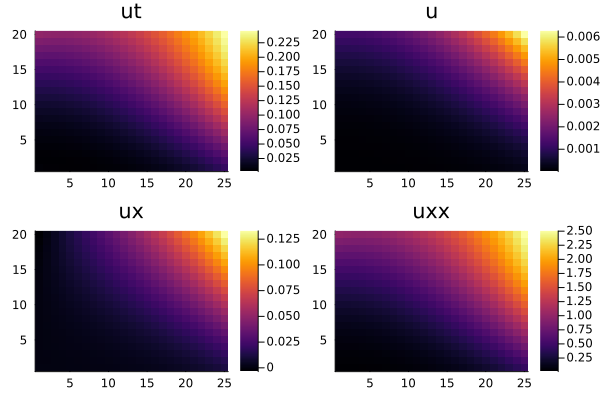

In [67]:
# prepare LHS
# make finite difference operator
∂t = TimeDerivative(g, order=4) # takes BC and order as arguments
dt_data_array = ∂t(data_array) 
dt_data_array_flat = reshape(dt_data_array, g.N) 

# prepare RHS
# construct relevant variables from highest order spatial derivative to consider
∂x = XDerivative(g; order=4, boundary_condition="neumann") # takes BC and order as arguments
max_derivative_degree = 3
variables_matrix = GetVariablesMatrix(max_derivative_degree, data_array, g, ∂x)

# check accuracy of numerical derivatives
using Plots
# a,b = 1:size(data_array, 1),1:size(data_array, 2)
a,b = 1:20,1:25
p1 = heatmap(reshape(dt_data_array_flat ,(g.nt,g.nx))[a,b], title="ut")
p2 = heatmap(reshape(variables_matrix[1],(g.nt,g.nx))[a,b], title="u")
p3 = heatmap(reshape(variables_matrix[2],(g.nt,g.nx))[a,b], title="ux")
p4 = heatmap(reshape(variables_matrix[3],(g.nt,g.nx))[a,b], title="uxx")
plot(p1, p2, p3, p4, layout = (2,2))

In [68]:
# construct basis functions, eg: polynomial basis
max_poly_degree = 2
n_variables = max_derivative_degree + 1 # include 0th-derivative i.e. function itself
MyBasis = PolynomialBasis(max_poly_degree, n_variables, skip_constant = false)

# theta matrix
Θ = evaluate(MyBasis, variables_matrix)
# cond_number = norm(Θ,2) * norm(pinv(Θ),2)

37901×15 Matrix{Float64}:
 1.0  3.72665e-6    0.000186285   0.0089155  …    0.00394137      0.195436
 1.0  1.0405e-5    -5.567e-8      0.0280186       0.00133713      0.00227747
 1.0  1.65386e-5   -6.97142e-8    0.0383884       0.00126703      0.00108937
 1.0  2.55246e-5   -1.94703e-7    0.0519687       0.00169685      0.00106611
 1.0  3.76028e-5   -5.94436e-7    0.0693281       0.00229692      0.00109768
 1.0  5.35562e-5   -1.67709e-6    0.090759   …    0.00278841      0.000943913
 1.0  7.42341e-5   -4.27228e-6    0.116609        0.00257615      0.000488066
 1.0  0.000100554  -9.89596e-6    0.147211        0.000391316     7.06597e-6
 1.0  0.000133496  -2.10918e-5    0.182863       -0.006207        0.00115215
 1.0  0.000174098  -4.18368e-5    0.22382        -0.0215247       0.00924855
 ⋮                                           ⋱                 
 1.0  0.349006      0.0917561    -4.02409       143.05         1263.7
 1.0  0.347935      0.102835     -3.91685       142.638        1326.17

Perform sequential thresholded ridge regression at *fixed threshold* and *fixed* $\lambda$.

In [70]:
# perform ridge regression
STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-5, tol = 1e-1, iters = 4, verbose = true, normalize_columns = false)

Iteration: 4, threshold: 0.1. 
Iteration: 3, threshold: 0.1. 
Iteration: 2, threshold: 0.1. 
Iteration: 1, threshold: 0.1. 


Current fit: 
 $ \\ \partial_t u = \textcolor{grey}{\xi_{0000}} + \textcolor{grey}{\xi_{1000}u} + \textcolor{grey}{\xi_{0100}\partial_{x} u} + \xi_{0010}\partial_{xx} u + \textcolor{grey}{\xi_{0001}\partial_{xxx} u} + \textcolor{grey}{\xi_{2000}(u)^2} + \xi_{1100}u\partial_{x} u + \textcolor{grey}{\xi_{1010}u\partial_{xx} u} + \textcolor{grey}{\xi_{1001}u\partial_{xxx} u} + \textcolor{grey}{\xi_{0200}(\partial_{x} u)^2} + \textcolor{grey}{\xi_{0110}\partial_{x} u\partial_{xx} u} + \textcolor{grey}{\xi_{0101}\partial_{x} u\partial_{xxx} u} + \textcolor{grey}{\xi_{0020}(\partial_{xx} u)^2} + \textcolor{grey}{\xi_{0011}\partial_{xx} u\partial_{xxx} u} + \textcolor{grey}{\xi_{0002}(\partial_{xxx} u)^2} \\ $ with: $ \\\textcolor{grey}{\xi_{0000} = 0.0 \\ }\textcolor{grey}{\xi_{1000} = -0.03 \\ }\textcolor{grey}{\xi_{0100} = -0.0 \\ }\xi_{0010} = 0.1 \\ \textcolor{grey}{\xi_{0001} = -0.0 \\ }\textcolor{grey}{\xi_{2000} = 0.06 \\ }\xi_{1100} = -5.98 \\ \textcolor{grey}{\xi_{1010} = 0.01 \\ }\textcolor{grey}{\xi_{1001} = 0.0 \\ }\textcolor{grey}{\xi_{0200} = 0.0 \\ }\textcolor{grey}{\xi_{0110} = -0.0 \\ }\textcolor{grey}{\xi_{0101} = 0.0 \\ }\textcolor{grey}{\xi_{0020} = -0.0 \\ }\textcolor{grey}{\xi_{0011} = 0.0 \\ }\textcolor{grey}{\xi_{0002} = -0.0 \\ }$ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u + \xi_{1100}u\partial_{x} u \\ $ with: $ \\\xi_{0010} = 0.1 \\ \xi_{1100} = -5.99 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u + \xi_{1100}u\partial_{x} u \\ $ with: $ \\\xi_{0010} = 0.1 \\ \xi_{1100} = -5.99 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{0010}\partial_{xx} u + \xi_{1100}u\partial_{x} u \\ $ with: $ \\\xi_{0010} = 0.1 \\ \xi_{1100} = -5.99 \\ $ 
 - - -

([0.10307628893556717, -5.992286220344973], Any[[0, 0, 1, 0], [1, 1, 0, 0]])

The threshold landscape exploration. 

In [86]:
using LinearAlgebra, Plots
N = g.N
cond_number = cond(Θ, 2)

tol_range = 10.0 .^ (-5:1e-2:1.0)
L2_error²_array = zero(tol_range)
L0_error²_array = zero(tol_range)

for (i,tol) in enumerate(tol_range)
    ξ, active_poly_vectors = STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ=1e-5, tol=tol, iters=4)
    chosen_mask = MyBasis.poly_vectors .∈ Ref(active_poly_vectors)
    L2_error²_array[i] = norm(Θ[:, chosen_mask] * ξ - dt_data_array_flat, 2)^2
    L0_error²_array[i] = norm(ξ, 0)^2
end

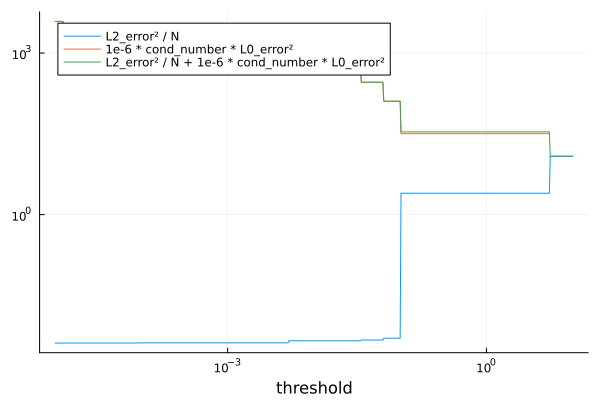

In [87]:
plot(tol_range, L2_error²_array ./ N, xscale=:log10, yscale=:log10, label="L2_error² / N", xlabel="threshold", legend=:topleft)
plot!(tol_range[L0_error²_array .> 0.], 1e-6 .* cond_number .* L0_error²_array[L0_error²_array .> 0.], label="1e-6 * cond_number * L0_error²")
plot!(tol_range, L2_error²_array ./ N + 1e-6 .* cond_number .* L0_error²_array, label="L2_error² / N + 1e-6 * cond_number * L0_error²")

Perform the choice of optimal threshold at *fixed* $\lambda$.

In [88]:
TrainSTRidge(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-5, tol_multiplier=1.0, iters = 5, verbose = true, cond_number_multiplier=1e-6,  max_tol_iters = 40)

Split input data to 30321 train and 7580 test samples. 
Using η = 1.0e-6 * 3.185851518765224e7. 
tol_iter = 1: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-5.469909331100549]. Decreased Threshold to 3.60304160466944. 
tol_iter = 2: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-5.469909331100549]. Decreased Threshold to 1.80152080233472. 
tol_iter = 3: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-5.469909331100549]. Decreased Threshold to 0.90076040116736. 
tol_iter = 4: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-5.469909331100549]. Decreased Threshold to 0.45038020058368. 
tol_iter = 5: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-5.469909331100549]. Decreased Threshold to 0.22519010029184. 
tol_iter = 6: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-5.469909331100549]. Decreased Threshold to 0.11259505014592. 
tol_iter = 7: Stepsize too big. Decreased tol_multi

([0.10354103573569635, -5.9955010075644255], Any[[0, 0, 1, 0], [1, 1, 0, 0]])

Investigate behaviour at different $\lambda$.

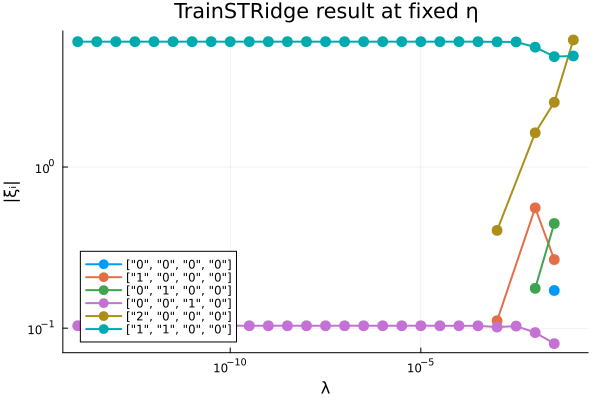

In [89]:
lambda_range = 10.0 .^ (-14.0:0.5:1.0)
to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5)

using Plots
plt = plot(legend=:bottomleft, xlabel="λ", ylabel="|ξᵢ|", title="TrainSTRidge result at fixed η")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end
display(plt)

## Many contributions 
Repeat the above for 
$$\partial_t u(t,x) = u(t,x) - 3 u(t,x) \partial_x u(t,x) + 0.1 \partial_{xx} u(t,x) - 0.4 \partial_x u(t,x),$$
on 

In [106]:
# prepare mock data - copied from https://docs.sciml.ai/MethodOfLines/dev/tutorials/heat/
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets

# Parameters, variables, and derivatives
@parameters t x
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2
Dxxx = Differential(x)^3

# 1D PDE and boundary conditions
eq  = Dt(u(t, x)) ~ u(t,x) - 3 * u(t,x) * Dx(u(t, x)) + 0.1 * Dxx(u(t,x)) - 0.4 * Dx(u(t,x))
bcs = [u(0, x) ~ (exp(- (x-0.5)^2 / (2 * 0.1^2))),
        u(t, 0) ~ u(t, 1)
        ]

# Space and time domains
domains = [t ∈ Interval(0.0, 1.0),
           x ∈ Interval(0.0, 1.0)]

# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])

# Method of lines discretization
dx = 0.002
order = 2 # not used
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)

# Solve ODE problem
sol = solve(prob, Tsit5(), saveat=0.001)

┌ Warning: The system contains interface boundaries, which are not compatible with system transformation. The system will not be transformed. Please post an issue if you need this feature.
└ @ MethodOfLines /home/natan/.julia/packages/MethodOfLines/glDxX/src/system_parsing/pde_system_transformation.jl:42


L"\begin{align}
 - 0.1 \frac{\mathrm{d}}{\mathrm{d}x} \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) + 0.4 \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) + \frac{\mathrm{d}}{\mathrm{d}t} u\left( t, x \right) - u\left( t, x \right) + 3 \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) u\left( t, x \right) =& 0
\end{align}
"

L"\begin{align}
u\left( 0, x \right) =& e^{ - 50 \left( -0.5 + x \right)^{2}} \\
u\left( t, 0 \right) =& u\left( t, 1 \right)
\end{align}
"

PDESolution:
  Return Code:
    Success
  Dependent variables:
    u(t, x): (1001, 501) sized solution
  Domain:
    t ∈ (0.0, 1.0) with 1001 points, step size 0.001
    x ∈ (0.0, 1.0) with 501 points, step size 0.002
  From system:
    Equations:
    Boundary/Initial Conditions:


In [107]:
using PDEfind

We pretend that all that is given are the following arrays, which we collect in a grid structure.

In [110]:
# start with given data
time_range = 0.0:0.002:1.0
space_range = 0.0:0.004:1.0
data_array = sol(time_range, space_range)[1]
time_array = collect(time_range)
space_array= collect(space_range)

# initialize grid
g = TimeSpaceGrid1D(time_array, space_array)

TimeSpaceGrid1D{Float64}([0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018  …  0.982, 0.984, 0.986, 0.988, 0.99, 0.992, 0.994, 0.996, 0.998, 1.0], [0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036  …  0.964, 0.968, 0.972, 0.976, 0.98, 0.984, 0.988, 0.992, 0.996, 1.0], 0.002, 0.004, 501, 251, 125751, [0.0 0.002 … 0.998 1.0; 0.0 0.002 … 0.998 1.0; … ; 0.0 0.002 … 0.998 1.0; 0.0 0.002 … 0.998 1.0], [0.0 0.0 … 0.0 0.0; 0.004 0.004 … 0.004 0.004; … ; 0.996 0.996 … 0.996 0.996; 1.0 1.0 … 1.0 1.0])

We are solving an equation of the type $\partial_t u_(t,x) = \mathcal L [u(t,x)]$ for unknown $\mathcal L$. 

In this example we assume $\mathcal L$ is a polynomial in $u, \partial_x u, \partial_{xx} u$. Using notation from Rudy et al., we prepare the $\Theta$ matrix. 

Note: `normalization_factors` are an irrelevant trick used for stability of the algorithm.

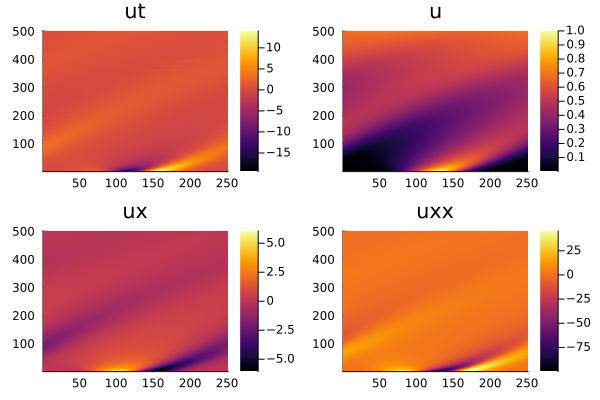

In [111]:
# prepare LHS
# make finite difference operator
∂t = TimeDerivative(g, order=4) # takes BC and order as arguments
dt_data_array = ∂t(data_array) 
dt_data_array_flat = reshape(dt_data_array, g.N) 

# prepare RHS
# construct relevant variables from highest order spatial derivative to consider
∂x = XDerivative(g; order=4, boundary_condition="neumann") # takes BC and order as arguments
max_derivative_degree = 3
variables_matrix = GetVariablesMatrix(max_derivative_degree, data_array, g, ∂x)

# check accuracy of numerical derivatives
using Plots
a,b = 1:size(data_array, 1),1:size(data_array, 2)
# a,b = 1:20,1:25
p1 = heatmap(reshape(dt_data_array_flat ,(g.nt,g.nx))[a,b], title="ut")
p2 = heatmap(reshape(variables_matrix[1],(g.nt,g.nx))[a,b], title="u")
p3 = heatmap(reshape(variables_matrix[2],(g.nt,g.nx))[a,b], title="ux")
p4 = heatmap(reshape(variables_matrix[3],(g.nt,g.nx))[a,b], title="uxx")
plot(p1, p2, p3, p4, layout = (2,2))

In [112]:
# construct basis functions, eg: polynomial basis
max_poly_degree = 2
n_variables = max_derivative_degree + 1 # include 0th-derivative i.e. function itself
MyBasis = PolynomialBasis(max_poly_degree, n_variables, skip_constant = false)

# theta matrix
Θ = evaluate(MyBasis, variables_matrix)
# cond_number = norm(Θ,2) * norm(pinv(Θ),2)

125751×15 Matrix{Float64}:
 1.0  3.72665e-6    0.000186285   0.0089155  …   0.00394137   0.195436
 1.0  8.89215e-6   -2.5289e-5     0.0303101      0.00136785   0.00203657
 1.0  1.60943e-5   -6.32638e-5    0.0391492     -0.00245391   0.00392891
 1.0  2.59432e-5   -0.000126447   0.0527041     -0.0084391    0.0256391
 1.0  3.84906e-5   -0.000225816   0.0707101     -0.0203507    0.0828317
 1.0  5.52055e-5   -0.000371248   0.0931301  …  -0.0425308    0.208558
 1.0  7.70815e-5   -0.000575374   0.120407      -0.0810737    0.453378
 1.0  0.000105203  -0.000852454   0.152987      -0.144415     0.89108
 1.0  0.000140757  -0.00121836    0.191295      -0.243872     1.62522
 1.0  0.000185028  -0.00169057    0.235728      -0.39424      2.79706
 ⋮                                           ⋱               
 1.0  0.67271       0.092007     -0.349573       1.27484     13.2996
 1.0  0.673569      0.093655     -0.319893       1.13774     12.6497
 1.0  0.674403      0.0946762    -0.299045       1.06164    

Perform sequential thresholded ridge regression at *fixed threshold* and *fixed* $\lambda$.

In [113]:
# perform ridge regression
STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-5, tol = 5e-2, iters = 4, verbose = true, normalize_columns = false)

Iteration: 4, threshold: 0.05. 
Iteration: 3, threshold: 0.05. 
Iteration: 2, threshold: 0.05. 
Iteration: 1, threshold: 0.05. 


Current fit: 
 $ \\ \partial_t u = \textcolor{grey}{\xi_{0000}} + \xi_{1000}u + \xi_{0100}\partial_{x} u + \xi_{0010}\partial_{xx} u + \textcolor{grey}{\xi_{0001}\partial_{xxx} u} + \textcolor{grey}{\xi_{2000}(u)^2} + \xi_{1100}u\partial_{x} u + \textcolor{grey}{\xi_{1010}u\partial_{xx} u} + \textcolor{grey}{\xi_{1001}u\partial_{xxx} u} + \textcolor{grey}{\xi_{0200}(\partial_{x} u)^2} + \textcolor{grey}{\xi_{0110}\partial_{x} u\partial_{xx} u} + \textcolor{grey}{\xi_{0101}\partial_{x} u\partial_{xxx} u} + \textcolor{grey}{\xi_{0020}(\partial_{xx} u)^2} + \textcolor{grey}{\xi_{0011}\partial_{xx} u\partial_{xxx} u} + \textcolor{grey}{\xi_{0002}(\partial_{xxx} u)^2} \\ $ with: $ \\\textcolor{grey}{\xi_{0000} = 0.005 \\ }\xi_{1000} = 0.995 \\ \xi_{0100} = -0.408 \\ \xi_{0010} = 0.1 \\ \textcolor{grey}{\xi_{0001} = 0.0 \\ }\textcolor{grey}{\xi_{2000} = -0.014 \\ }\xi_{1100} = -2.973 \\ \textcolor{grey}{\xi_{1010} = 0.005 \\ }\textcolor{grey}{\xi_{1001} = 0.0 \\ }\textcolor{grey}{\xi_{0200} = -0.001 \\ }\textcolor{grey}{\xi_{0110} = 0.0 \\ }\textcolor{grey}{\xi_{0101} = -0.0 \\ }\textcolor{grey}{\xi_{0020} = 0.0 \\ }\textcolor{grey}{\xi_{0011} = 0.0 \\ }\textcolor{grey}{\xi_{0002} = 0.0 \\ }$ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{1000}u + \xi_{0100}\partial_{x} u + \xi_{0010}\partial_{xx} u + \xi_{1100}u\partial_{x} u \\ $ with: $ \\\xi_{1000} = 0.993 \\ \xi_{0100} = -0.397 \\ \xi_{0010} = 0.102 \\ \xi_{1100} = -3.004 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{1000}u + \xi_{0100}\partial_{x} u + \xi_{0010}\partial_{xx} u + \xi_{1100}u\partial_{x} u \\ $ with: $ \\\xi_{1000} = 0.993 \\ \xi_{0100} = -0.397 \\ \xi_{0010} = 0.102 \\ \xi_{1100} = -3.004 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{1000}u + \xi_{0100}\partial_{x} u + \xi_{0010}\partial_{xx} u + \xi_{1100}u\partial_{x} u \\ $ with: $ \\\xi_{1000} = 0.993 \\ \xi_{0100} = -0.397 \\ \xi_{0010} = 0.102 \\ \xi_{1100} = -3.004 \\ $ 
 - - -

([0.9932984917521034, -0.39660454064304085, 0.10205796140328932, -3.004051847573975], Any[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 1, 0, 0]])

The threshold landscape exploration. 

In [114]:
using LinearAlgebra, Plots
N = g.N
cond_number = cond(Θ, 2)

tol_range = 10.0 .^ (-5:1e-2:1.0)
L2_error²_array = zero(tol_range)
L0_error²_array = zero(tol_range)

for (i,tol) in enumerate(tol_range)
    ξ, active_poly_vectors = STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ=1e-5, tol=tol, iters=4)
    chosen_mask = MyBasis.poly_vectors .∈ Ref(active_poly_vectors)
    L2_error²_array[i] = norm(Θ[:, chosen_mask] * ξ - dt_data_array_flat, 2)^2
    L0_error²_array[i] = norm(ξ, 0)^2
end

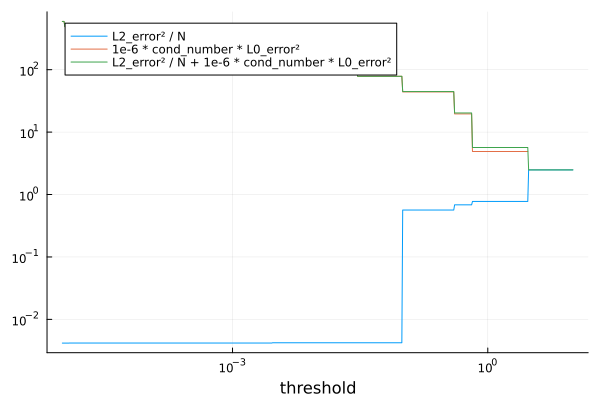

In [115]:
plot(tol_range, L2_error²_array ./ N, xscale=:log10, yscale=:log10, label="L2_error² / N", xlabel="threshold", legend=:topleft)
plot!(tol_range[L0_error²_array .> 0.], 1e-6 .* cond_number .* L0_error²_array[L0_error²_array .> 0.], label="1e-6 * cond_number * L0_error²")
plot!(tol_range, L2_error²_array ./ N + 1e-6 .* cond_number .* L0_error²_array, label="L2_error² / N + 1e-6 * cond_number * L0_error²")

Perform the choice of optimal threshold at *fixed* $\lambda$.

In [116]:
TrainSTRidge(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-5, tol_multiplier=1.0, iters = 5, verbose = true, cond_number_multiplier=1e-6,  max_tol_iters = 40)

Split input data to 100601 train and 25150 test samples. 
Using η = 1.0e-6 * 4.891503392162506e6. 
tol_iter = 1: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-3.5181502229246484]. Decreased Threshold to 2.7760531477886956. 
tol_iter = 2: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-3.5181502229246484]. Decreased Threshold to 1.3880265738943478. 
tol_iter = 3: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-3.5181502229246484]. Decreased Threshold to 0.6940132869471739. 
tol_iter = 4: Stepsize too big. Decreased tol_multiplier to 0.5. 
tol_iter = 5: Found better/equal fit with polynomials Any[[1, 0, 0, 0], [1, 1, 0, 0]], xi = [0.6333702227486504, -3.5372306491402923]. Decreased Threshold to 0.4626755246314493. 
tol_iter = 6: Found better/equal fit with polynomials Any[[1, 0, 0, 0], [0, 1, 0, 0], [1, 1, 0, 0]], xi = [0.6493404741984701, -0.7865435263844222, -1.962594605494737]. Decreased Threshold to 0.3084503497542995. 
tol_iter

([0.992856390836962, -0.39852306657895237, 0.10215880810395389, -3.000368660935895], Any[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 1, 0, 0]])

Investigate behaviour at different $\lambda$.

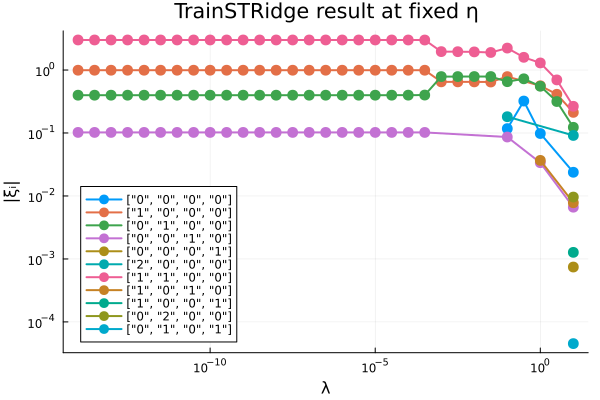

In [117]:
lambda_range = 10.0 .^ (-14.0:0.5:1.0)
to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5)

using Plots
plt = plot(legend=:bottomleft, xlabel="λ", ylabel="|ξᵢ|", title="TrainSTRidge result at fixed η")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end
display(plt)

In [ ]:
# tests for noise!
using NoiseRobustDifferentiation
# start with given data
time_range = 0.0:0.001:0.1
space_range = 0.0:0.01:1.0
data_array = sol(time_range, space_range)[1]
time_array = collect(time_range)
space_array= collect(space_range)

# initialize grid
g = TimeSpaceGrid1D(time_array, space_array)
# prepare LHS

dt_data_array = copy(data_array)
for i in 1:g.nx
    dt_data_array[:,i] = tvdiff(data_array[:,i], 1, 1e-9; dx=g.dt, scale="small", precond="none")
end

# prepare RHS
# construct relevant variables from highest order spatial derivative to consider
max_derivative_degree = 3
variables_matrix = [data_array]
current_array = copy(data_array)
for j in 1:g.nt
    current_array[j, :] = tvdiff(current_array[j, :], 100, 1e-5, dx=g.dx)            
end
push!(variables_matrix, current_array)
current_array2 = copy(current_array)
for j in 1:g.nt
    current_array2[j, :] = tvdiff(current_array2[j, :], 100, 1e-5, dx=g.dx)            
end
push!(variables_matrix, current_array2)
using Plots
p1 = heatmap(dt_data_array[1:20,1:15], title="ut")
p2 = heatmap(variables_matrix[1][1:20,1:15], title="u")
p3 = heatmap(variables_matrix[2][1:20,1:15], title="ux")
p4 = heatmap(variables_matrix[3][1:20,1:15], title="uxx")
plot(p1, p2, p3, p4, layout = (2,2))


In [ ]:
# comparison for heat analytic
true_sol = zero(data_array)
dt_true_sol = zero(data_array)
d1_true_sol = zero(data_array)
d2_true_sol = zero(data_array)
for (i,t) in enumerate(time_range), (j,x) in enumerate(space_range)
    true_sol[i,j] = exp(- pi^2 * t) * sin(pi*x) + 0.5 * exp(- 3.0^2 * pi^2 * t) * sin(3.0*pi*x) 
    dt_true_sol[i,j] = - pi^2 * exp(- pi^2 * t) * sin(pi*x) - 3.0^2 * 0.5 * pi^2 * exp(- 3.0^2 * pi^2 * t) * sin(3.0*pi*x) 
    d1_true_sol[i,j] = pi * exp(- pi^2 * t) * cos(pi*x) + 1.5 * pi * exp(- 3.0^2 * pi^2 * t) * cos(3.0*pi*x)
    d2_true_sol[i,j] = - pi^2 * exp(- pi^2 * t) * sin(pi*x) - 3.0^2 * 0.5 * pi^2 * exp(- 3.0^2 * pi^2 * t) * sin(3.0*pi*x) 
end
time_range = 0.0:0.001:0.1
space_range = 0.0:0.02:1.0
data_array = true_sol#sol(time_range, space_range)[1]
time_array = collect(time_range)
space_array= collect(space_range)

# initialize grid
g = TimeSpaceGrid1D(time_array, space_array)
# prepare LHS
# make finite difference operator
∂t = TimeDerivative(g) # takes BC and order as arguments
dt_data_array = ∂t(data_array) 
dt_data_array_flat = reshape(dt_data_array, g.N) 

# prepare RHS
# construct relevant variables from highest order spatial derivative to consider
∂x = XDerivative(g; degree=1, order=4) # takes BC and order as arguments
∂x² = XDerivative(g; degree=2, order=2) # takes BC and order as arguments
d1_data_array = ∂x(data_array)
d2_data_array = ∂x(∂x(data_array))
# d2_data_array = ∂x²(data_array)

variables_matrix = [reshape(data_array, g.N),reshape(d1_data_array, g.N),reshape(d2_data_array, g.N)] 

using Plots
p1 = heatmap(((dt_data_array - dt_true_sol)/dt_true_sol)[1:20,1:15], title="ut")
p2 = heatmap((data_array    -    true_sol)[1:20,1:15], title="u")
p3 = heatmap(((d1_data_array - d1_true_sol)/d1_true_sol)[1:20,1:15], title="ux")
p4 = heatmap(((d2_data_array - d2_true_sol)/d2_true_sol)[1:20,1:15], title="uxx")
plot(p1, p2, p3, p4, layout = (2,2))

In [ ]:
# proof that my norm is better
using LinearAlgebra
a, b, c, d = [], [], [], []
for dx in 0.002.*collect(1:1:10), dt in 0.001.*collect(1:1:20)
    # dt = 0.001
    # start with given data
    time_range = 0.0:dt:0.3
    space_range = 0.0:dx:1.0
    data_array = sol(time_range, space_range)[1]
    time_array = collect(time_range)
    space_array= collect(space_range)
    time_len= length(time_array)
    space_len= length(space_array)


    # initialize grid
    g = TimeSpaceGrid1D(time_array, space_array)
    # prepare LHS
    # make finite difference operator
    ∂t = TimeDerivative(g) # takes BC and order as arguments
    dt_data_array = ∂t(data_array) 
    dt_data_array_flat = reshape(dt_data_array, g.N) 

    # prepare RHS
    # construct relevant variables from highest order spatial derivative to consider
    ∂x = XDerivative(g; order=2) # takes BC and order as arguments
    max_derivative_degree = 2
    variables_matrix = GetVariablesMatrix(max_derivative_degree, data_array, g, ∂x)

    # construct basis functions, eg: polynomial basis
    max_poly_degree = 2
    n_variables = max_derivative_degree + 1 # include 0th-derivative i.e. function itself
    MyBasis = PolynomialBasis(max_poly_degree, n_variables, skip_constant = false)

    # theta matrix
    Θ = evaluate(MyBasis, variables_matrix)
    cond_number = cond(Θ, 2) #norm(Θ, 2) * norm(pinv(Θ),2)

    xi,_ = STRidge_cascade(Θ, dt_data_array_flat, MyBasis, λ = 1e2, tol = 0.0, iters = 1, verbose = false, normalize_columns = true)

    push!(a, time_len)
    push!(b, space_len)
    push!(c, cond_number)
    push!(d, norm(Θ * xi - dt_data_array_flat, 2)^2)
   
end

using Plots
N = a.*b
scatter(N, d .*1e3 ./N ./ c, xscale=:log10, yscale=:log10, label="Rudy et. al. norm", xlabel="N", ylabel="2-error / condition number multiplier")
scatter!(N, d .*1e6 ./N ./ c.^2, xscale=:log10, yscale=:log10, label="Modified norm")

In [ ]:
# investigate behaviour at different $\eta$.
to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5, cond_number_multiplier=1e-9)
p1 = plot(legend=:bottomleft, xlabel="λ", ylabel="|ξᵢ|", title="η = 1e-9")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end

to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5, cond_number_multiplier=1e-6)
p2 = plot(legend=:bottomleft, xlabel="λ", title="η = 1e-6")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end

to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5, cond_number_multiplier=1e-3)
p3 = plot(legend=:bottomleft, xlabel="λ", title="η = 1e-3")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end

plot(p1, p2, p3, layout = (1,3), sharey=true)